In [1]:
import os
import shutil
import cv2
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

In [2]:
dataset_path = 'datasets/MassachusettsRoads'

tiff_path = f'{dataset_path}/tiff'

train_path = f'{tiff_path}/train'
val_path = f'{tiff_path}/val'
test_path = f'{tiff_path}/test'

train_labels_path = f'{tiff_path}/train_labels'
val_labels_path = f'{tiff_path}/val_labels'
test_labels_path = f'{tiff_path}/test_labels'

In [3]:
def move_and_update(source_paths, destination_path):
    if not os.path.exists(destination_path):
        os.mkdir(destination_path)
    for source_path in source_paths:
        shutil.move(source_path, destination_path)
    return map(lambda path: destination_path + '/' + os.path.basename(path), source_paths)

In [10]:
train_path, val_path, test_path = move_and_update([train_path, 
                                                   val_path, 
                                                   test_path], 
                                                  f'{tiff_path}/images')
train_labels_path, val_labels_path, test_labels_path = move_and_update([train_labels_path, 
                                                                        val_labels_path, 
                                                                        test_labels_path],
                                                                       f'{tiff_path}/binary_masks')

In [4]:
def rename_and_update(paths, new_names):
    new_paths = []
    for path, new_name in zip(paths, new_names):
        base_name = os.path.basename(path)
        path_without_base_name = path[:-len(base_name)]
        new_path = f'{path_without_base_name}{new_name}'
        os.rename(path, new_path)
        new_paths.append(new_path)
    return new_paths

In [28]:
train_labels_path, val_labels_path, test_labels_path = rename_and_update([train_labels_path, 
                                                                          val_labels_path, 
                                                                          test_labels_path],
                                                                         ['train', 'val', 'test'])

In [6]:
def is_clockwise(contour):
    oriented_square = 0
    
    for i in range(len(contour) - 1):
        p1 = contour[i]
        p2 = contour[i + 1]
        oriented_square += p1[0] * p2[1] - p2[0] * p1[1]
        
    p1 = contour[len(contour) - 1]
    p2 = contour[0]
    oriented_square += p1[0] * p2[1] - p2[0] * p1[1]
    
    return oriented_square < 0

In [7]:
def get_merge_point_idx(contour1, contour2):
    idx1 = 0
    idx2 = 0
    distance_min = 1000000000
    
    for i, p1 in enumerate(contour1):
        for j, p2 in enumerate(contour2):
            distance = pow(p2[0] - p1[0], 2) + pow(p2[1] - p1[1], 2)
            if distance < distance_min:
                distance_min = distance
                idx1 = i
                idx2 = j
                
    return idx1, idx2

In [8]:
def merge_contours(contour1, contour2, idx1, idx2):
    contour = contour1[:idx1 + 1]
    contour = np.append(contour, contour2[idx2:], axis=0)
    contour = np.append(contour, contour2[:idx2 + 1], axis=0)
    contour = np.append(contour, contour1[idx1:], axis=0)
    return contour

In [9]:
def merge_with_parent(contour_parent, contour):
    if not is_clockwise(contour_parent):
        contour_parent = contour_parent[::-1]
    if is_clockwise(contour):
        contour = contour[::-1]
    idx1, idx2 = get_merge_point_idx(contour_parent, contour)
    return merge_contours(contour_parent, contour, idx1, idx2)

In [10]:
def mask2polygon(image):
    contours, hierarchies = cv2.findContours(image, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    contours = list(map(np.squeeze, contours))
    
    contours_parent = []
    for i, contour in enumerate(contours):
        parent_idx = hierarchies[0][i][3]
        if parent_idx < 0 and len(contour) > 2:
            contours_parent.append(contour)
        else:
            contours_parent.append([])

    for i, contour in enumerate(contours):
        parent_idx = hierarchies[0][i][3]
        if parent_idx >= 0 and len(contour) > 2:
            contour_parent = contours_parent[parent_idx]
            contours_parent[parent_idx] = merge_with_parent(contour_parent, contour)

    contours_parent_tmp = []
    for contour in contours_parent:
        if len(contour) == 0:
            continue
        contours_parent_tmp.append(contour)

    polygons = []
    for contour in contours_parent_tmp:
        polygon = contour.flatten().tolist()
        polygons.append(polygon)
    return polygons 

In [26]:
def make_annotations(annotations_path, images_path, masks_path):
    if not os.path.exists(annotations_path):
        os.mkdir(annotations_path)
        
    # if not os.path.exists(contours_path):
    #     os.mkdir(contours_path)
        
    for image_name in os.listdir(images_path):
        image = cv2.imread(f'{images_path}/{image_name}', cv2.IMREAD_COLOR)
        binary_mask = cv2.imread(f'{masks_path}/{image_name[:-1]}', cv2.IMREAD_GRAYSCALE)
        binary_mask_modified = binary_mask * (image < 250).any(axis=2)
        
        # contours, _ = cv2.findContours(binary_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        # cv2.drawContours(color_mask, contours, -1, (0, 255, 0), 1)
        # cv2.imwrite(f'{contours_path}/{image}', color_mask)
        
        polygons = mask2polygon(binary_mask_modified)
        
        if polygons:
            with open(f'{annotations_path}/{image_name[:-5]}.txt', 'w') as file:
                for polygon in polygons:
                    polygon = np.array(polygon, dtype=np.float32) / 1500
                    file.write('0 ' + ' '.join(str(coordinate) for coordinate in polygon) + '\n')

In [29]:
if not os.path.exists(f'{tiff_path}/labels__'):
    os.mkdir(f'{tiff_path}/labels__')

train_annotations_path = f'{tiff_path}/labels__/train'
val_annotations_path = f'{tiff_path}/labels__/val'
test_annotations_path = f'{tiff_path}/labels__/test'

# if not os.path.exists(f'{tiff_path}/contours'):
#     os.mkdir(f'{tiff_path}/contours')
# 
# train_contours_path = f'{tiff_path}/contours/train'
# val_contours_path = f'{tiff_path}/contours/val'
# test_contours_path = f'{tiff_path}/contours/test'

train_labels_path = f'{tiff_path}/binary_masks/train'
val_labels_path = f'{tiff_path}/binary_masks/val'
test_labels_path = f'{tiff_path}/binary_masks/test'

train_path = f'{tiff_path}/images/train'
val_path = f'{tiff_path}/images/val'
test_path = f'{tiff_path}/images/test'

In [ ]:
make_annotations(train_annotations_path, train_path, train_labels_path)
make_annotations(val_annotations_path, val_path, val_labels_path)
make_annotations(test_annotations_path, test_path, test_labels_path)

# ***Example***

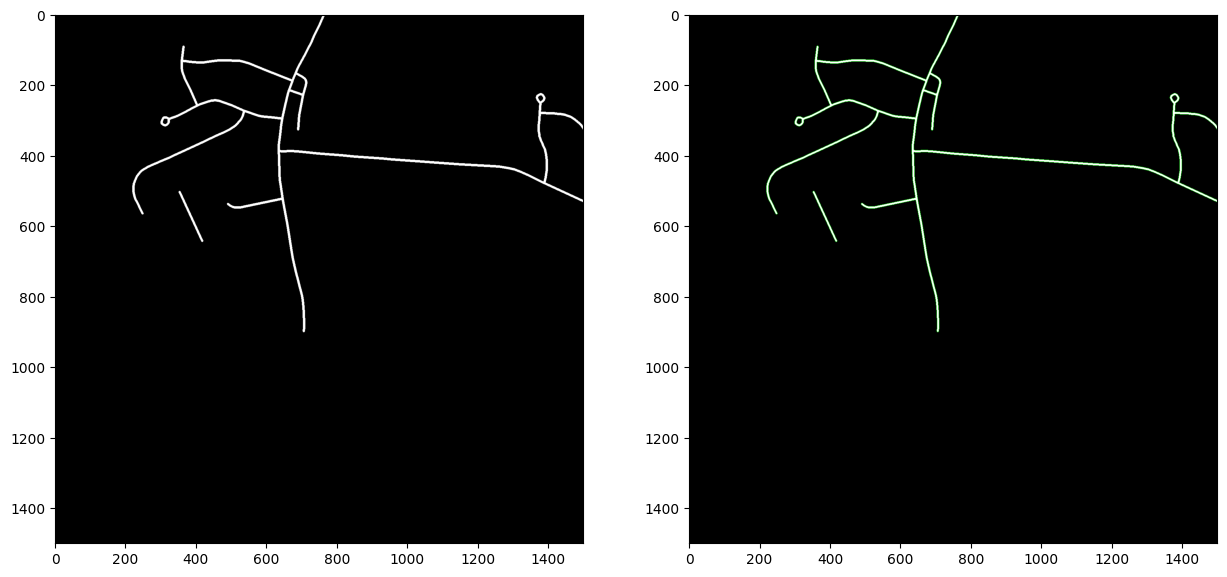

In [131]:
image_name = sorted(os.listdir(train_labels_path))[0]

gray_image = cv2.imread(f'{train_labels_path}/{image_name}', cv2.IMREAD_GRAYSCALE)
polygons = mask2polygon(gray_image)

points = []
for polygon in polygons:
    xs = polygon[::2]
    ys = polygon[1::2]
    points.append([[x, y] for x, y in zip(xs, ys)])

polygons = list(map(Polygon, points))
for polygon in polygons:
    display(polygon)

# plt.figure(figsize=(15, 20))
plt.imshow(gray_image, cmap='gray')
plt.show()